In [36]:
using Revise
using SSMCMain, SSMCMain.MinimalModelSemisymbolic
using CairoMakie
using Symbolics
import Nemo
using Base.Threads

In [2]:
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# Inspecting a single system

In [7]:
mmpf = MinimalModelParamsSpace(0.1, 1., 2., 2., 2., 1e-5, 500., 0.1);
mmicrm_params = mmp_to_mmicrm(mmpf);

In [9]:
xx = analyze_single_mmps(mmpf)

(1, 1, [[18.986832980505135, 0.05131670194948621, 0.05000000000000001]], [[1.707713444882653, 13.201803603144423]], [[0, 1, 0]])

## Numerics

In [20]:
all_sols = solve_nospace(mmpf)
display(all_sols)
nospace_sol_check_stable.(Ref(mmpf), all_sols)

3-element Vector{Vector{Float64}}:
 [18.986832980505135, 0.05131670194948621, 0.05000000000000001]
 [0.013167019494861876, 1.9486832980505142, 0.04999999999999954]
 [0.0, 2.0, 0.0]

3-element BitVector:
 1
 0
 1

In [22]:
nssol = all_sols[1];

#### Linstab

maximum(real(lambdas)) = 0.0018830706605796415


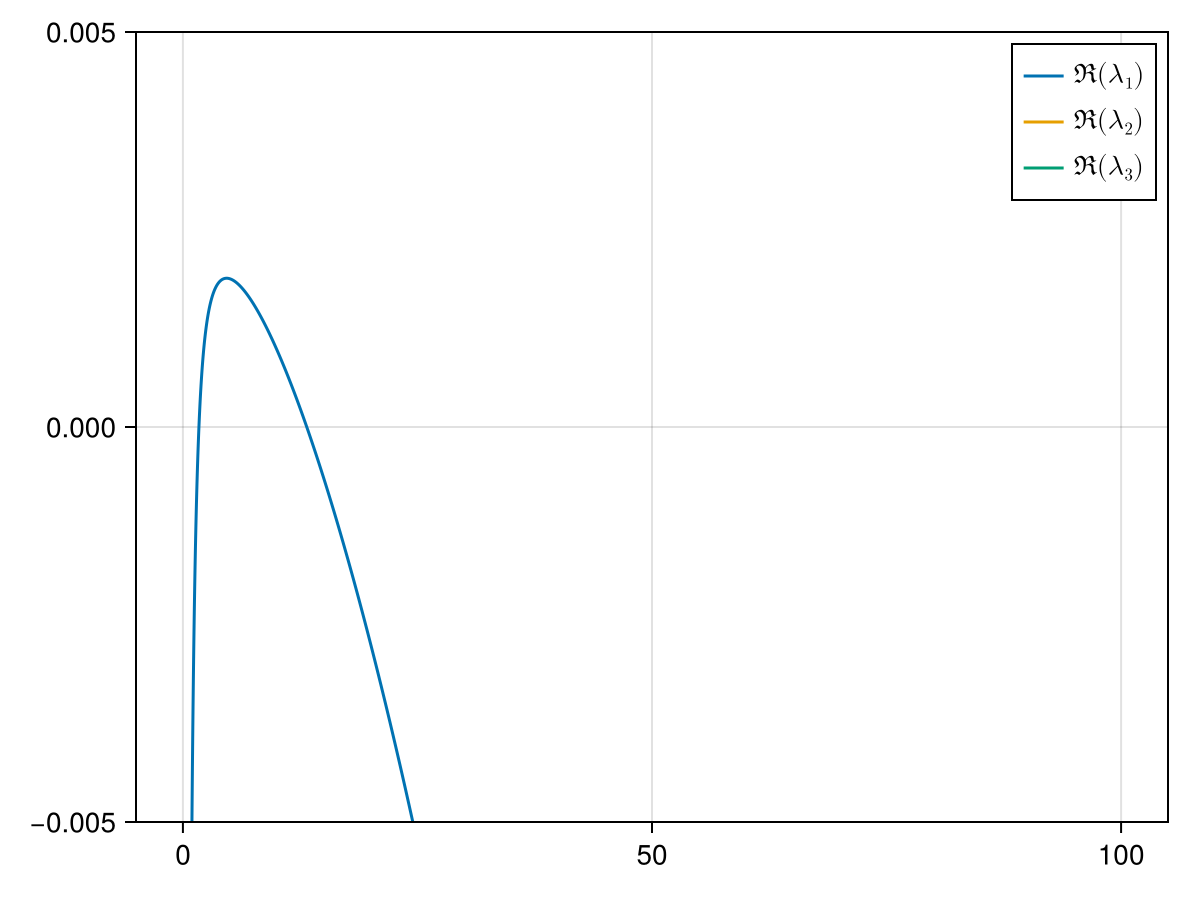

In [33]:
ks = LinRange(0., 100., 10000)
Ds = collect(get_Ds(mmpf))

lambdas = do_linstab_for_ks(ks, p, Ds, nssol);
@show maximum(real(lambdas))
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.005, 0.005))
# xlims!(faa.axis, (0., 2.))
# display(GLMakie.Screen(), faa.figure)
faa

In [34]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

3-element Vector{Float64}:
 -0.9999999984261414
  9.416817940584993e-6
 -5.530859456984734e-5

### 1D PDE sim

In [37]:
ssize = (1000,)
su0 = expand_u0_to_size(ssize, nssol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.01, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 10000000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((3, 1000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.01]))

In [38]:
@time sps = solve(sp, QNDF(); maxiters=1000)
print_spatial_solution_stats(sps)

  6.389574 seconds (17.21 M allocations: 1.597 GiB, 5.56% gc time, 186.16% compilation time)
Success
nf is 2523
solution has 426 saved states
max resid is 1.05537e-09


┌ Warning: reaching negative values, minimum is -3.61443e-06
└ @ SSMCMain.SpaceMMiCRM ~/Sync/University/PhD/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/smmicrm_util.jl:10


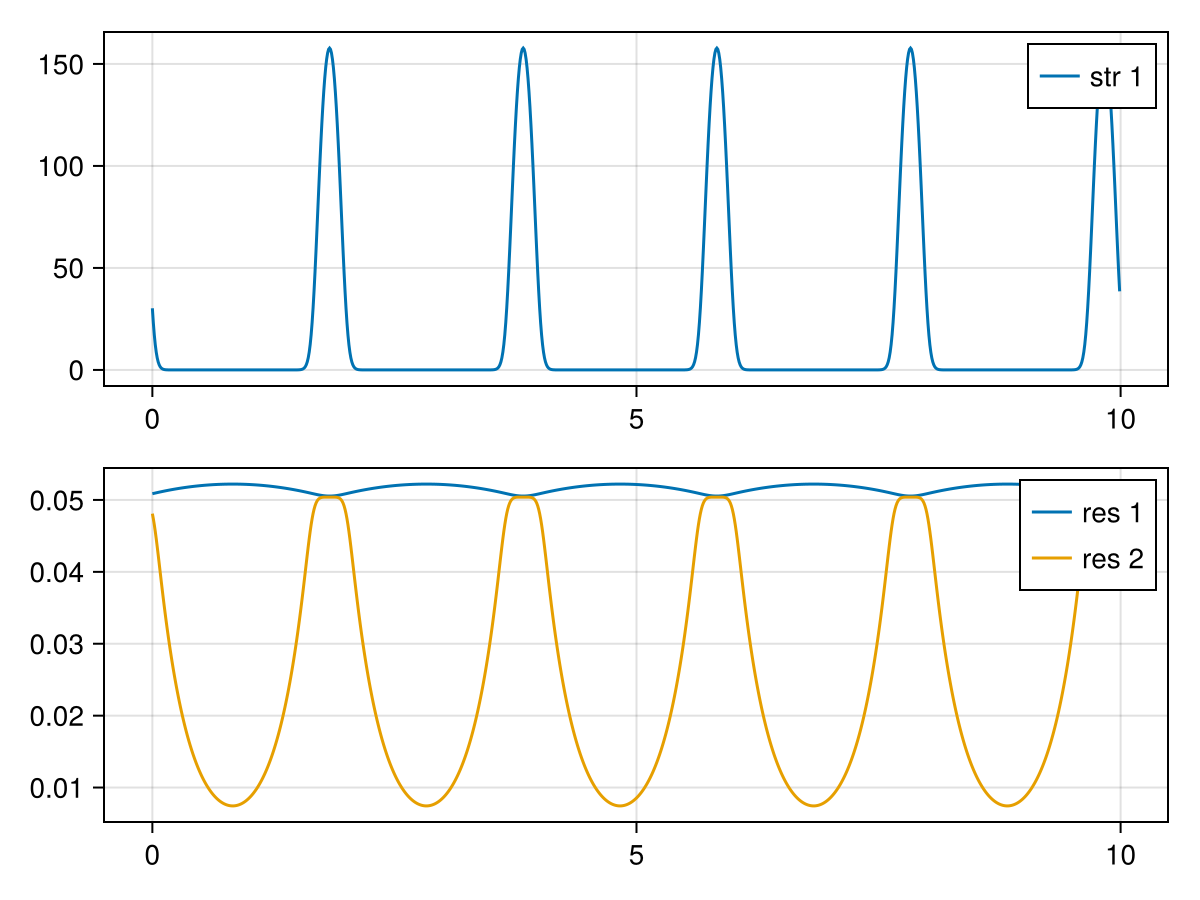

In [44]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

# Bits and bobs

### Testing

In [19]:
xx = solve_nospace(mmpf)

3-element Vector{Vector{Float64}}:
 [18.986832980505135, 0.05131670194948621, 0.05000000000000001]
 [0.013167019494861876, 1.9486832980505142, 0.04999999999999954]
 [0.0, 2.0, 0.0]

In [21]:
M1 = make_M1(mmicrm_params, xx[1])

3×3 Matrix{Float64}:
  1.38778e-17    0.0      37.9737
 -0.102633     -38.9737    0.0
  0.0026334     37.9737  -38.9737

In [33]:
pol = make_K_polynomial(M1, get_Ds(mmpf))

4-element SVector{4, Float64} with indices SOneTo(4):
   -0.0005
   -0.19490730347101168
   49.98481053361589
 -144.099930651839

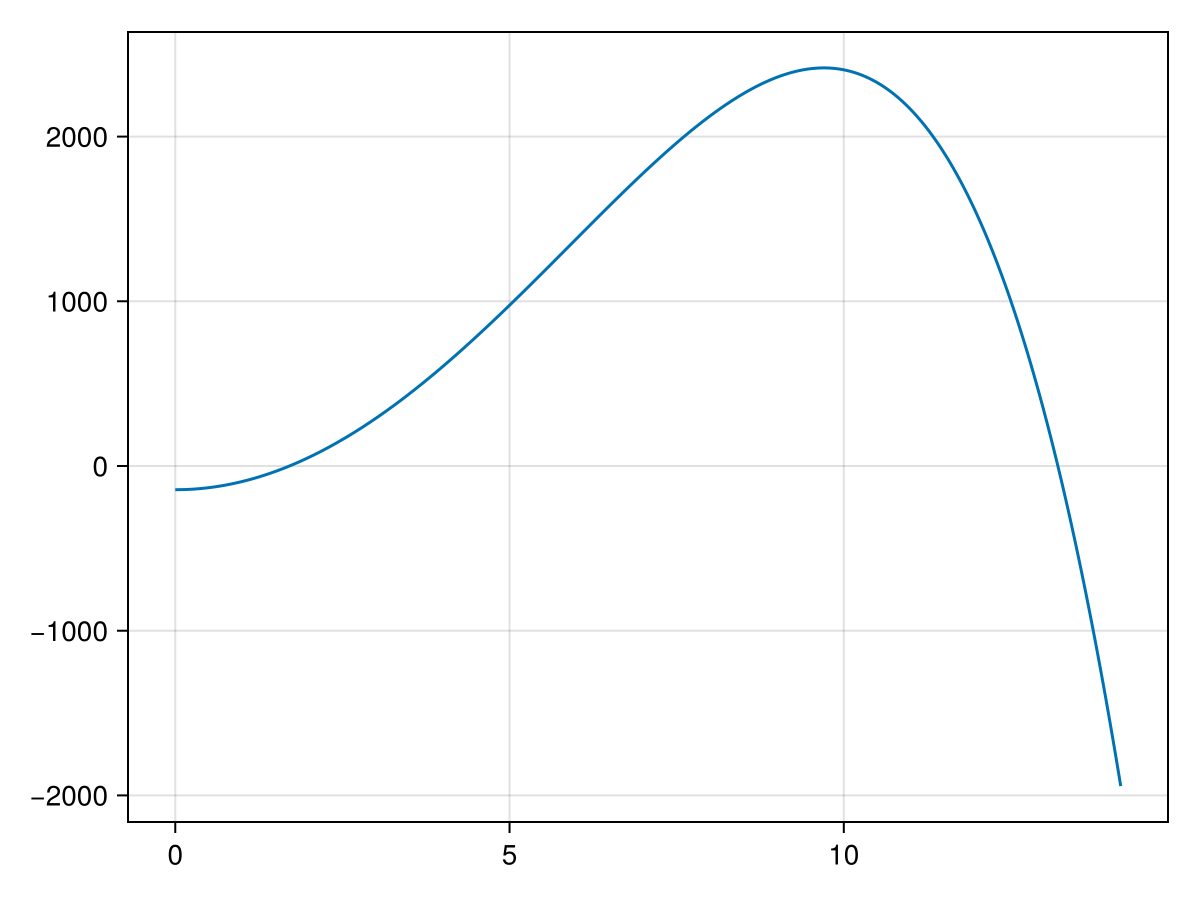

In [64]:
fks = LinRange(0, 200, 10000)
yy = eval_cubic.(Ref(pol), fks)
lines(sqrt.(fks), yy)

### Finding params so that D=0

In [45]:
@variables a b c d x p q t;
sx = t - 3*b / a
st = x + 3*b / a
display(sx)
display(st)

t + (-3b) / a

x + (3b) / a

In [47]:
ep = (3*a*c - b^2) / (3*a^2)
eq = (2*b^3 - 9*a*b*c + 27*a^2*d) / (27*a^3)
display(ep)
display(eq)

(3a*c - (b^2)) / (3(a^2))

(27(a^2)*d - 9a*b*c + 2(b^3)) / (27(a^3))

In [48]:
eD = q^2/4 + p^3/27
display(eD)

(1//4)*(q^2) + (1//27)*(p^3)

In [52]:
fD = simplify(substitute(substitute(eD, p=>ep), q=>eq))

((27//1)*(a^2)*(d^2) - (18//1)*a*b*c*d + (4//1)*a*(c^3) + (4//1)*(b^3)*d - (b^2)*(c^2)) / (108(a^4))

In [63]:
D0_sd = simplify(symbolic_solve(fD~0, d))

2-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 (√(-432(a^3)*(c^3) + 432(a^2)*(b^2)*(c^2) - 144a*(b^4)*c + 16(b^6)) + 18a*b*c - 4(b^3)) / (54(a^2))
 (-√(-432(a^3)*(c^3) + 432(a^2)*(b^2)*(c^2) - 144a*(b^4)*c + 16(b^6)) + 18a*b*c - 4(b^3)) / (54(a^2))

In [77]:
simplify(substitute(D0_sd[1], [a=>1,b=>1,c=>0.1]))

0.002641631005470585571790650969636567983439420046482461039933878046183213123669783